## CREDIT CARD FRAUD DETECTION

### Context
##### What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

Three challenges surrounding credit card fraud
It's not always easy to agree on ground truth for what "fraud" means.
Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
Most merchants aren't experts at evaluating the business impact of fraud.

Problem Statement:
The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.

Observations
Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of 492 frauds in a total of 284,807 observations. This resulted in only 0.172% fraud cases. This skewed set is justified by the low number of fraudulent transactions.
The dataset consists of numerical values from the 28 ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
The ‘Time’ and ‘Amount’ features are not transformed data.
There is no missing value in the dataset.

Why does class imbalanced affect model performance?
In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

What is the catch?
Training a model on a balanced dataset optimizes performance on validation data.
However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: Time, Amount

How different is the amount of money used in different transaction classes?
Do fraudulent transactions occur more often during a certain frames?

### Dataset
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. 

Due to confidentiality issues, there are not provided the original features and more background information about the data

1. Features V1, V2, ... V28 are the principal components obtained with PCA;
2. The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
3. Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

#### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from collections import Counter # counter takes values returns value_counts dictionary
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



np.random.seed(2)

Using TensorFlow backend.
/Users/archita/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [2]:
df = pd.read_csv('../Dataset/creditcard.csv')

## CHECK THE DATA

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("Credit Card Fraud Detection data -  rows:",df.shape[0]," columns:", df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Looking at the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).
#### Looking at the Amount feature, we can say that there's a wide range of amount, so scaling the data prior to running the model will provide better results.

## CHECKING MISSING DATA

In [6]:
#Let's check if there's any missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### There are no missing values in the entire dataset

## DATA IMBALANCE

In [7]:
# get class distribution
print ("Normal transaction:", df['Class'][df['Class']==0].count()) #class = 0
print ("Fraudulent transaction:", df['Class'][df['Class']==1].count()) #class = 1

Normal transaction: 284315
Fraudulent transaction: 492


In [8]:
temp = df["Class"].value_counts()
df_class = pd.DataFrame({'Class': temp.index,'values': temp.values})

In [9]:
#visualizing the class label
trace = go.Bar(
    x = df_class['Class'],y = df_class['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df_class['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=800
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

#### As we can observe, the dataset is highly imbalanced with only 492 cases i.e 0.17% of the observations being in the Fraudulent category.

## DATA EXPLORATION

In [10]:
# separate classes into different datasets
normal_class = df.query('Class == 0')
fraudulent_class = df.query('Class == 1')

# randomize the datasets
normal_class = normal_class.sample(frac=1,random_state=69)
fraudulent_class = fraudulent_class.sample(frac=1,random_state=69)

### TRANSACTIONS IN TIME

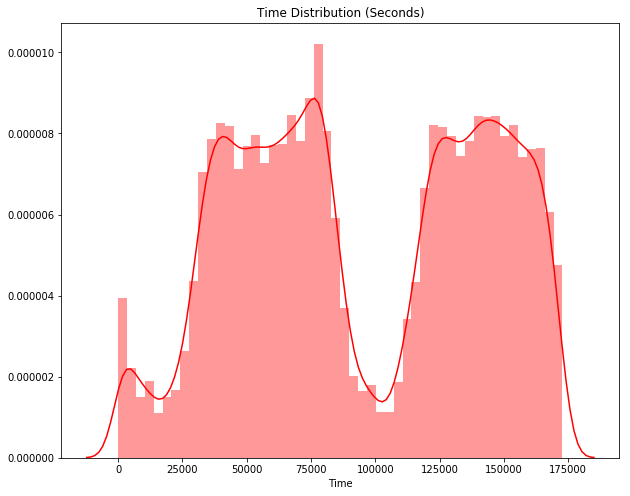

In [11]:
#plot the time feature
plt.figure(figsize=(10,8), )
plt.title('Time Distribution (Seconds)')
sns.distplot(df['Time'],color='red');

### Given that this distribution is two days’ worth of data, it would follow the trend I’d expect to see for normal consumers. Most purchases are made during the daylight hours, and as people get out of work/school and head home, purchasing dwindles down until the next day.

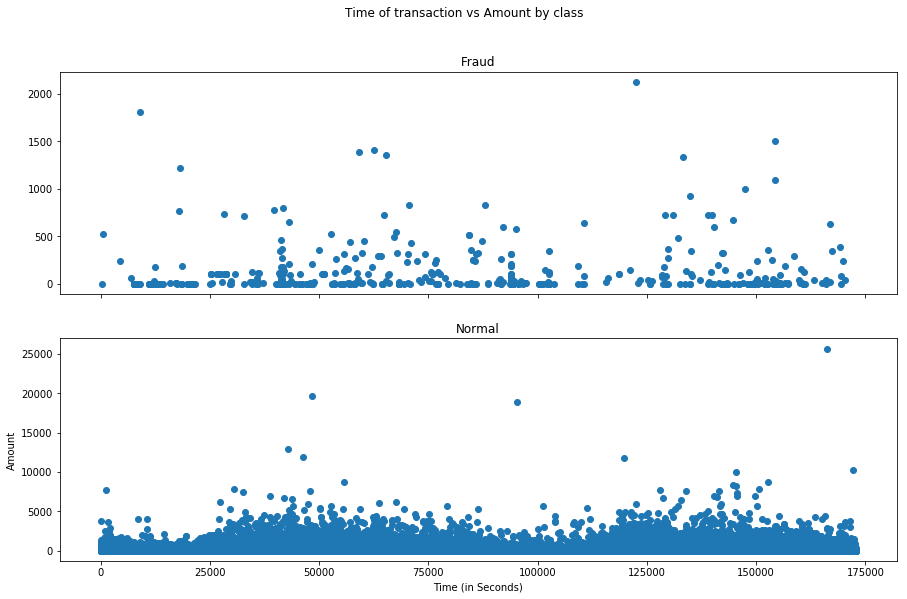

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudulent_class.Time, fraudulent_class.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal_class.Time, normal_class.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### The above graph shows that Time is irrelevent for detecting fraudulent transactions

### AMOUNT DISTRIBUTION

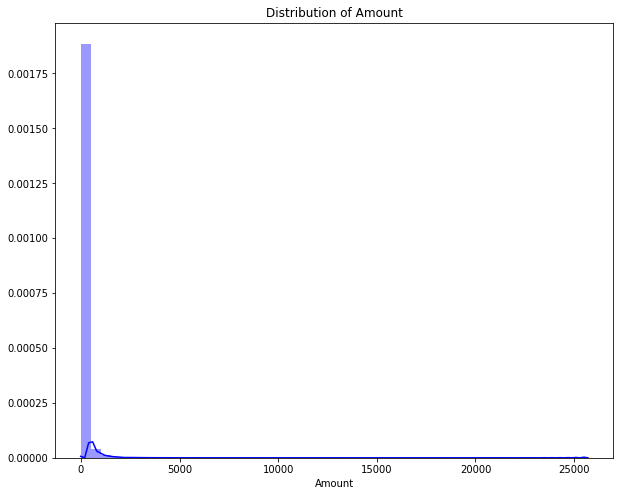

In [13]:
#plot the amount feature
plt.figure(figsize=(10,8))
plt.title('Distribution of Amount')
sns.distplot(df['Amount'],color='blue');

### While the vast majority of transactions are very low, this distribution is also expected. Most daily transactions aren’t extremely expensive (most are < 50), but it’s likely where most fraudulent transactions are occurring as well.

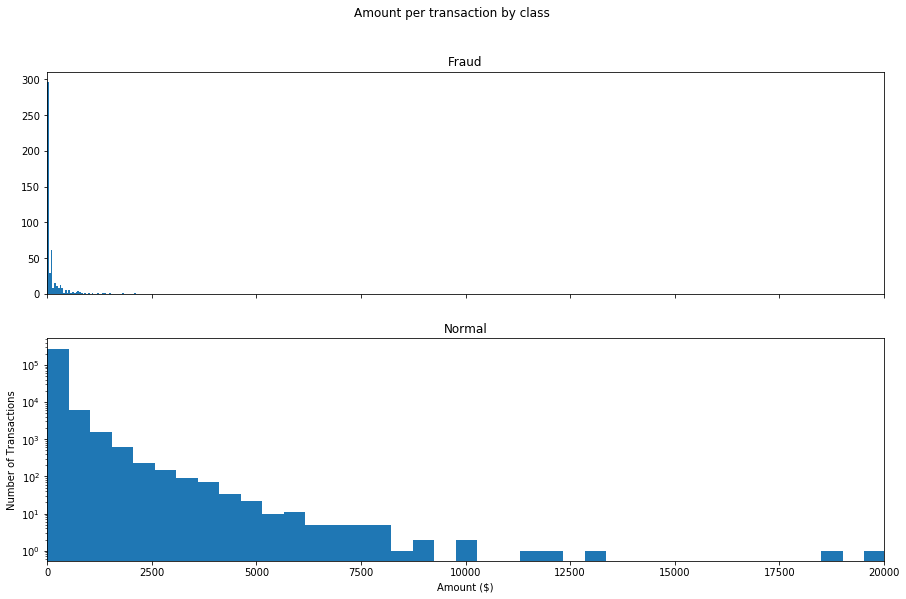

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudulent_class.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal_class.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### The above graph shows that most of the fraudulent transactions are of very low amount

## CORRELATION MATRIX

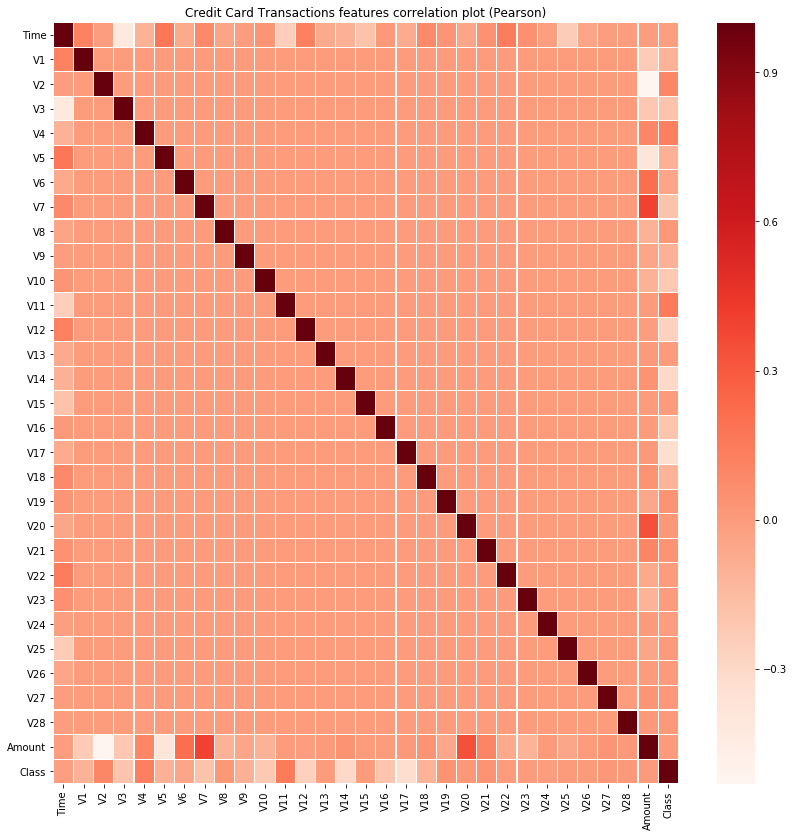

In [15]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

#### As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

### STANDARDSCALAR ON TIME AND AMOUNT

In [16]:
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

## PREDICTIVE MODELS

### Define predictors and target values
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [17]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#### Split data in train and test set
Let's define train and test sets.

In [18]:
X = df[predictors]
y = df[target]

In [19]:
# Use stratify to ensure samples of fraud label are in the test set
#stratify split is used when there is misclassified data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


In [20]:
y_train.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

## TRAIN THE MODELS

#### We are aware that our dataset is highly imbalanced, however, we check the performance of imbalance dataset first and later we implement some techniques to balance the dataset and again check the performance of balanced dataset. Finally, we will compare each models performance.
### Let's start with a Logistic Regression model.

In [22]:
from sklearn.linear_model import LogisticRegression # Importing Classifier Step

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 

/Users/archita/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [24]:
y_pred = logreg.predict(X_test)

### Model Evaluation

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, r2_score, roc_auc_score, roc_curve, auc

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.71      0.79       123

    accuracy                           1.00     71202
   macro avg       0.95      0.85      0.90     71202
weighted avg       1.00      1.00      1.00     71202



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred , y_test))) 
print('AUC : {0:0.5f}'.format(roc_auc_score(y_test , y_pred)))
print('Precision : {0:0.5f}'.format(precision_score(y_test , y_pred)))
print('Recall : {0:0.5f}'.format(recall_score(y_test , y_pred)))
print('F1 : {0:0.5f}'.format(f1_score(y_test , y_pred)))
# print('Confusion Matrix : \n', cnf_matrix)
print("\n")

Accuracy :0.99937
AUC : 0.85360
Precision : 0.90625
Recall : 0.70732
F1 : 0.79452




In [29]:
# Predicted values counts for fraud and genuine of test dataset
# Our model predicted 96 transactions as fraud and 71106 transactions as genuine from the test dataset.
pd.Series(y_pred).value_counts()

0    71106
1       96
dtype: int64

In [30]:
# Actual values counts for fraud and genuine of test dataset
pd.Series(y_test).value_counts()

0    71079
1      123
Name: Class, dtype: int64

In [31]:
# There are originally 123 fraud transactions and our model predicted only 96 fraud transaction. 
# So the accuracy of our model should be  96/123 , right?
96/123

0.7804878048780488

#### So 78.048% should be our accuracy rate

However, this not the case. Actually there are originally 123 fraud transactions and 71079 genuine transactions in the test dataset. However, our model predicted only 96 fraud transaction. Also, it should be kept in mind that these 96 predicted fraud transaction may not be identified correctly. It means that these predicted 96 fraud transactions are NOT only from 123 originally fraud transaction, but they may also be from genuine transactions as well.

We will see our real accuracy in below cells.

#### MODEL EVALUATION MATRIX
Every problem is different and derives a different set of values for a particular business use case , thus every model must be evaluated differently.

In [32]:
#confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)

[[71070     9]
 [   36    87]]


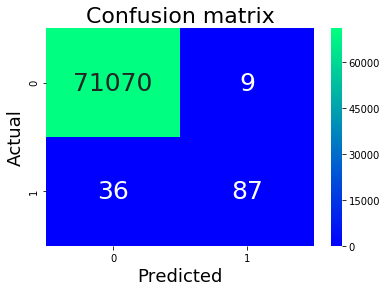

In [33]:
#heatmap for confusion matrix
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, annot_kws={"size": 25}, cmap="winter" ,fmt='g')

plt.title('Confusion matrix', y=1.1, fontsize = 22)
plt.ylabel('Actual',fontsize = 18)
plt.xlabel('Predicted',fontsize = 18)

plt.show()

In [34]:
## We already know that we have 123 fraud transaction in our test dataset, but our model predicted only 87 fraud transaction. So the real accuracy of our model is:
87/123

0.7073170731707317

#### So, 70.73% is the real accuracy of our model, which is nothing but the Recall Score. So we have the emphasis on Recall score and F1 score to measure the performance of our model, not the accuracy.

### Receiver Operating Characteristics (ROC)
The ROC is a performance measurement for classification problems at various thresholds. It is essentially a probability curve, and the higher the Area Under the Curve (AUC) score the better the model is at predicting fraudulent/non-fraudulent transactions.

In [35]:
#ROC-AUC SCORE
roc_auc_score(y_test , y_pred) 

0.8535952267470169

In [36]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba

array([[9.99860796e-01, 1.39203623e-04],
       [9.98757005e-01, 1.24299521e-03],
       [9.99787428e-01, 2.12571953e-04],
       ...,
       [9.99880730e-01, 1.19270009e-04],
       [9.99581496e-01, 4.18504229e-04],
       [9.99788724e-01, 2.11276295e-04]])

AUC -  0.8535952267470169 



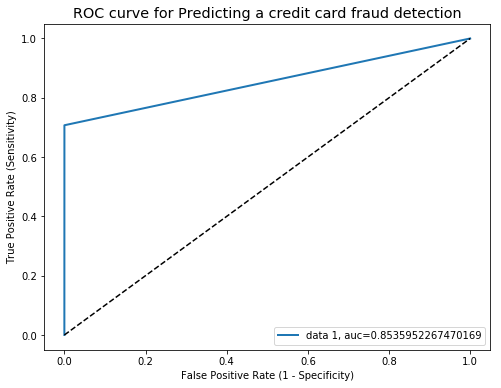

In [37]:
# plot ROC Curve

plt.figure(figsize=(8,6))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

### Let's Build different models with different balanced datasets, first by creating multiple datasets for undersampled , oversampled and SMOTE sampled

## UnderSampled Data

In [38]:
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_under))

# Slit into train and test datasets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, shuffle=True, test_size=0.3, random_state=0)

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 492, 1: 492})


## OverSampled Data

In [39]:
print('Original dataset shape %s' % Counter(y))

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_over))

# Slit into train and test datasets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.3, shuffle=True, random_state=0)

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})


## SMOTE Data

In [40]:
print('Original dataset shape %s' % Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_smote))

# Slit into train and test datasets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, shuffle=True, random_state=0)

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})


## ADASYN Data

In [41]:
print('Original dataset shape %s' % Counter(y))

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_adasyn))

# Slit into train and test datasets
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, test_size=0.3, shuffle=True, random_state=0)

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284306})


## FUNCTION FOR MODEL BUILDING AND PERFORMANCE MEASURE

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb



RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

/Users/archita/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [54]:
names_lst = []

# Empty list to capture performance matrix for train set
aucs_train_lst = []
accuracy_train_lst = []
precision_train_lst = []
recall_train_lst = []
f1_train_lst = []

# Empty list to capture performance matrix for test set
aucs_test_lst = []
accuracy_test_lst = []
precision_test_lst = []
recall_test_lst = []
f1_test_lst = []

# Function for model building and performance measure

def build_measure_model(models):
    plt.figure(figsize=(12,6))

    for name, model,Xdata,ydata in models:
        
        names_lst.append(name)

        # split data in train test set
        X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.3, shuffle=True, random_state=0)
        
        # Build model
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # calculate accuracy
        Accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_train_lst.append(Accuracy_train)
        
        Accuracy_test = accuracy_score(y_test, y_test_pred)
        accuracy_test_lst.append(Accuracy_test)

        # calculate auc
        Aucs_train = roc_auc_score(y_train, y_train_pred)
        aucs_train_lst.append(Aucs_train)
        
        Aucs_test = roc_auc_score(y_test , y_test_pred)
        aucs_test_lst.append(Aucs_test)

        # calculate precision
        PrecisionScore_train = precision_score(y_train , y_train_pred)
        precision_train_lst.append(PrecisionScore_train)
        
        PrecisionScore_test = precision_score(y_test , y_test_pred)
        precision_test_lst.append(PrecisionScore_test)

        # calculate recall
        RecallScore_train = recall_score(y_train , y_train_pred)
        recall_train_lst.append(RecallScore_train)
        
        RecallScore_test = recall_score(y_test , y_test_pred)
        recall_test_lst.append(RecallScore_test)

        # calculate f1 score
        F1Score_train = f1_score(y_train , y_train_pred)
        f1_train_lst.append(F1Score_train)
        
        F1Score_test = f1_score(y_test , y_test_pred)
        f1_test_lst.append(F1Score_test)

        #print('F1 Score of '+ name +' model : {0:0.5f}'.format(F1Score_test))

        # draw confusion matrix
        cnf_matrix = confusion_matrix(y_test , y_test_pred)
        cnf_matrix_lst.append(cnf_matrix)

        print("Model Name :", name)
        
        print('Train Accuracy :{0:0.5f}'.format(Accuracy_train)) 
        print('Test Accuracy :{0:0.5f}'.format(Accuracy_test))
        
        print('Train AUC : {0:0.5f}'.format(Aucs_train))
        print('Test AUC : {0:0.5f}'.format(Aucs_test))
        
        print('Train Precision : {0:0.5f}'.format(PrecisionScore_train))
        print('Test Precision : {0:0.5f}'.format(PrecisionScore_test))
        
        print('Train Recall : {0:0.5f}'.format(RecallScore_train))
        print('Test Recall : {0:0.5f}'.format(RecallScore_test))
        
        print('Train F1 : {0:0.5f}'.format(F1Score_train))
        print('Test F1 : {0:0.5f}'.format(F1Score_test))
        
        print('Confusion Matrix : \n', cnf_matrix)
        print("\n")


        # plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
        auc = roc_auc_score(y_test, y_test_pred)
        plt.plot(fpr,tpr,linewidth=2, label=name + ", auc="+str(auc))
    
        #---------- For loops ends here--------#


    plt.legend(loc=4)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting a credit card fraud detection')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

## 1. LOGISTIC REGRESSION(LR)

Model Name : LR imbalance
Train Accuracy :0.99921
Test Accuracy :0.99920
Train AUC : 0.81152
Test AUC : 0.80945
Train Precision : 0.88477
Test Precision : 0.88350
Train Recall : 0.62319
Test Recall : 0.61905
Train F1 : 0.73129
Test F1 : 0.72800
Confusion Matrix : 
 [[85284    12]
 [   56    91]]


Model Name : LR Undersampling
Train Accuracy :0.95640
Test Accuracy :0.94257
Train AUC : 0.95632
Test AUC : 0.94277
Train Precision : 0.98154
Test Precision : 0.97143
Train Recall : 0.93003
Test Recall : 0.91275
Train F1 : 0.95509
Test F1 : 0.94118
Confusion Matrix : 
 [[143   4]
 [ 13 136]]


Model Name : LR Oversampling
Train Accuracy :0.94954
Test Accuracy :0.94898
Train AUC : 0.94952
Test AUC : 0.94902
Train Precision : 0.97675
Test Precision : 0.97572
Train Recall : 0.92094
Test Recall : 0.92103
Train F1 : 0.94802
Test F1 : 0.94759
Confusion Matrix : 
 [[83214  1958]
 [ 6745 78672]]


Model Name : LR SMOTE
Train Accuracy :0.94777
Test Accuracy :0.94804
Train AUC : 0.94776
Test AUC : 0.94

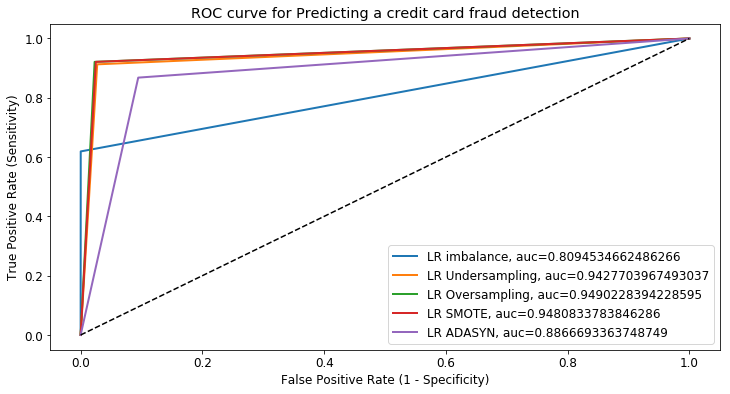

None


In [44]:
#------------------ Logistic Regression (LR) ------------------#
LRmodels = []

LRmodels.append(('LR imbalance', LogisticRegression(solver='liblinear', multi_class='ovr'),X,y))
LRmodels.append(('LR Undersampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_under,y_under))
LRmodels.append(('LR Oversampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_over,y_over))
LRmodels.append(('LR SMOTE', LogisticRegression(solver='liblinear', multi_class='ovr'),X_smote,y_smote))
LRmodels.append(('LR ADASYN', LogisticRegression(solver='liblinear', multi_class='ovr'),X_adasyn,y_adasyn))

# Call function to create model and measure its performance
print(build_measure_model(LRmodels))

## 2. DECISION TREE(DT)

Model Name : DT imbalance
Train Accuracy :1.00000
Test Accuracy :0.99927
Train AUC : 1.00000
Test AUC : 0.87740
Train Precision : 1.00000
Test Precision : 0.81022
Train Recall : 1.00000
Test Recall : 0.75510
Train F1 : 1.00000
Test F1 : 0.78169
Confusion Matrix : 
 [[85270    26]
 [   36   111]]


Model Name : DT Undersampling
Train Accuracy :1.00000
Test Accuracy :0.88176
Train AUC : 1.00000
Test AUC : 0.88191
Train Precision : 1.00000
Test Precision : 0.90141
Train Recall : 1.00000
Test Recall : 0.85906
Train F1 : 1.00000
Test F1 : 0.87973
Confusion Matrix : 
 [[133  14]
 [ 21 128]]


Model Name : DT Oversampling
Train Accuracy :1.00000
Test Accuracy :0.99979
Train AUC : 1.00000
Test AUC : 0.99979
Train Precision : 1.00000
Test Precision : 0.99958
Train Recall : 1.00000
Test Recall : 1.00000
Train F1 : 1.00000
Test F1 : 0.99979
Confusion Matrix : 
 [[85136    36]
 [    0 85417]]


Model Name : DT SMOTE
Train Accuracy :1.00000
Test Accuracy :0.99829
Train AUC : 1.00000
Test AUC : 0.99

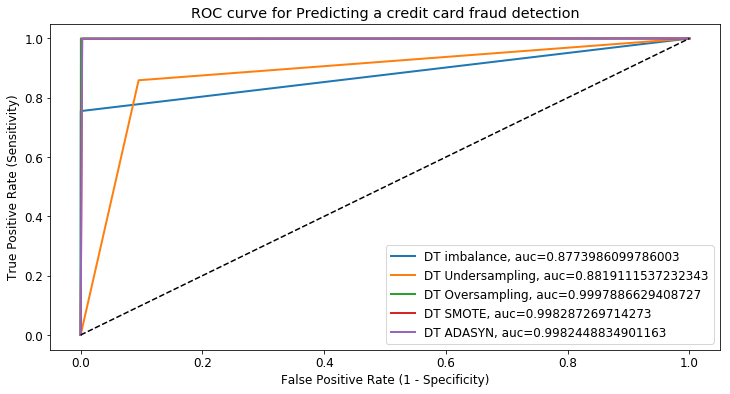

In [45]:
#-----------------Decision Tree (DT)------------------#
DTmodels = []

dt = DecisionTreeClassifier()

DTmodels.append(('DT imbalance', dt,X,y))
DTmodels.append(('DT Undersampling', dt,X_under,y_under))
DTmodels.append(('DT Oversampling', dt,X_over,y_over))
DTmodels.append(('DT SMOTE', dt,X_smote,y_smote))
DTmodels.append(('DT ADASYN', dt,X_adasyn,y_adasyn))

# Call function to create model and measure its performance
build_measure_model(DTmodels)

## 3. RANDOM FOREST(RF)

Model Name : RF imbalance
Train Accuracy :1.00000
Test Accuracy :0.99953
Train AUC : 1.00000
Test AUC : 0.88092
Train Precision : 1.00000
Test Precision : 0.95726
Train Recall : 1.00000
Test Recall : 0.76190
Train F1 : 1.00000
Test F1 : 0.84848
Confusion Matrix : 
 [[85291     5]
 [   35   112]]


Model Name : RF Undersampling
Train Accuracy :1.00000
Test Accuracy :0.94257
Train AUC : 1.00000
Test AUC : 0.94291
Train Precision : 1.00000
Test Precision : 0.99254
Train Recall : 1.00000
Test Recall : 0.89262
Train F1 : 1.00000
Test F1 : 0.93993
Confusion Matrix : 
 [[146   1]
 [ 16 133]]


Model Name : RF Oversampling
Train Accuracy :1.00000
Test Accuracy :0.99997
Train AUC : 1.00000
Test AUC : 0.99997
Train Precision : 1.00000
Test Precision : 0.99994
Train Recall : 1.00000
Test Recall : 1.00000
Train F1 : 1.00000
Test F1 : 0.99997
Confusion Matrix : 
 [[85167     5]
 [    0 85417]]


Model Name : RF SMOTE
Train Accuracy :1.00000
Test Accuracy :0.99991
Train AUC : 1.00000
Test AUC : 0.99

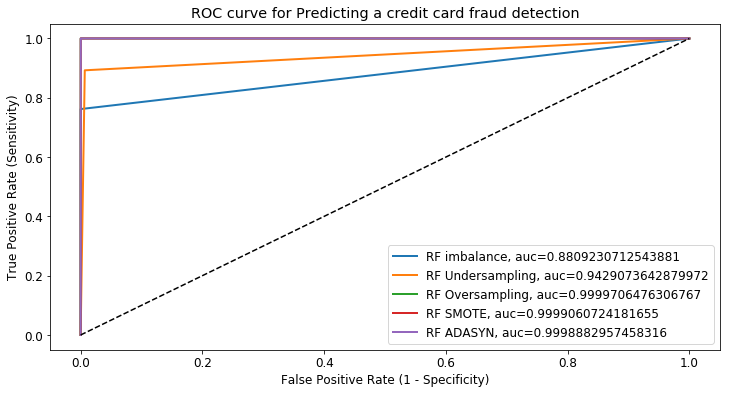

In [46]:
#-----------------Random Forest (RF) ------------------#
RFmodels = []

clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

RFmodels.append(('RF imbalance', clf,X,y))
RFmodels.append(('RF Undersampling', clf,X_under,y_under))
RFmodels.append(('RF Oversampling', clf,X_over,y_over))
RFmodels.append(('RF SMOTE', clf,X_smote,y_smote))
RFmodels.append(('RF ADASYN', clf,X_adasyn,y_adasyn))

# Call function to create model and measure its performance
build_measure_model(RFmodels)

## 4. XG BOOST

Model Name : XG imbalance
Train Accuracy :0.99925
Test Accuracy :0.99916
Train AUC : 0.81154
Test AUC : 0.78906
Train Precision : 0.91489
Test Precision : 0.89474
Train Recall : 0.62319
Test Recall : 0.57823
Train F1 : 0.74138
Test F1 : 0.70248
Confusion Matrix : 
 [[85286    10]
 [   62    85]]


Model Name : XG Undersampling
Train Accuracy :0.94477
Test Accuracy :0.92905
Train AUC : 0.94462
Test AUC : 0.92953
Train Precision : 0.99353
Test Precision : 1.00000
Train Recall : 0.89504
Test Recall : 0.85906
Train F1 : 0.94172
Test F1 : 0.92419
Confusion Matrix : 
 [[147   0]
 [ 21 128]]


Model Name : XG Oversampling
Train Accuracy :0.96968
Test Accuracy :0.96918
Train AUC : 0.96966
Test AUC : 0.96922
Train Precision : 0.99569
Test Precision : 0.99539
Train Recall : 0.94340
Test Recall : 0.94282
Train F1 : 0.96884
Test F1 : 0.96839
Confusion Matrix : 
 [[84799   373]
 [ 4884 80533]]


Model Name : XG SMOTE
Train Accuracy :0.94998
Test Accuracy :0.94990
Train AUC : 0.94995
Test AUC : 0.94

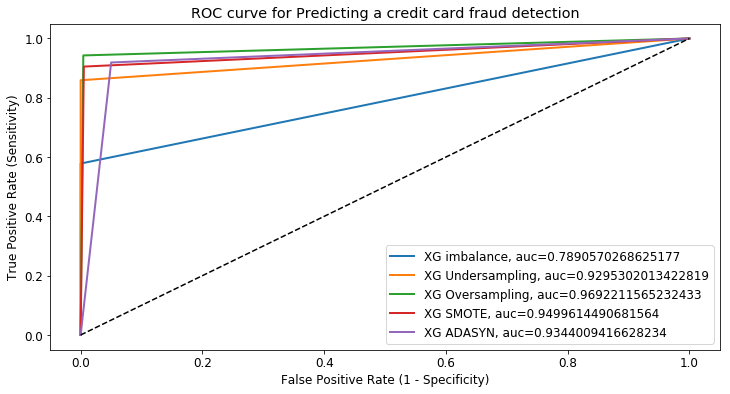

In [47]:
#-----------------XG BOOST(XG) ------------------#
XGmodels = []

# Prepare the train and valid datasets
#data_dmatrix = xgb.DMatrix(data=X,label=y)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, eval_metric ='auc', random_state = RANDOM_STATE)

XGmodels.append(('XG imbalance', xgb_model,X,y))
XGmodels.append(('XG Undersampling', xgb_model,X_under,y_under))
XGmodels.append(('XG Oversampling', xgb_model,X_over,y_over))
XGmodels.append(('XG SMOTE', xgb_model,X_smote,y_smote))
XGmodels.append(('XG ADASYN', xgb_model,X_adasyn,y_adasyn))

# Call function to create model and measure its performance
build_measure_model(XGmodels)

### Performance measures of various classifiers

In [50]:
data = {'Model':names_lst,
       'Accuracy_Train':accuracy_train_lst,
       'Accuracy_Test':accuracy_test_lst,
       'AUC_Train':aucs_train_lst,
       'AUC_Test':aucs_test_lst,
       'PrecisionScore_Train':precision_train_lst,
       'PrecisionScore_Test':precision_test_lst,
       'RecallScore_Train':recall_train_lst,
       'RecallScore_Test':recall_test_lst,
       'F1Score_Train':f1_train_lst,
       'F1Score_Test':f1_test_lst}

In [53]:
print("Performance measures of various classifiers: \n")
performance_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ])) 
performance_df.sort_values(['AUC_Test','RecallScore_Test','F1Score_Test'],ascending=False)

Performance measures of various classifiers: 



,Model,Accuracy_Train,Accuracy_Test,AUC_Train,AUC_Test,PrecisionScore_Train,PrecisionScore_Test,RecallScore_Train,RecallScore_Test,F1Score_Train,F1Score_Test
12,RF Oversampling,1.000000,0.999971,1.000000,0.999971,1.000000,0.999941,1.000000,1.000000,1.000000,0.999971
13,RF SMOTE,1.000000,0.999906,1.000000,0.999906,1.000000,0.999813,1.000000,1.000000,1.000000,0.999906
14,RF ADASYN,1.000000,0.999889,1.000000,0.999888,1.000000,0.999778,1.000000,1.000000,1.000000,0.999889
7,DT Oversampling,1.000000,0.999789,1.000000,0.999789,1.000000,0.999579,1.000000,1.000000,1.000000,0.999789
8,DT SMOTE,1.000000,0.998288,1.000000,0.998287,1.000000,0.997592,1.000000,0.998993,1.000000,0.998292
9,DT ADASYN,1.000000,0.998247,1.000000,0.998245,1.000000,0.997456,1.000000,0.999053,1.000000,0.998254
17,XG Oversampling,0.969676,0.969183,0.969660,0.969221,0.995686,0.995390,0.943403,0.942822,0.968840,0.968393
18,XG SMOTE,0.949978,0.949897,0.949950,0.949961,0.994568,0.994252,0.904836,0.905171,0.947582,0.947623
2,LR Oversampling,0.949540,0.948983,0.949523,0.949023,0.976751,0.975716,0.920939,0.921034,0.948024,0.947587
3,LR SMOTE,0.947774,0.948045,0.947757,0.948083,0.974464,0.973655,0.919582,0.921163,0.946228,0.946682


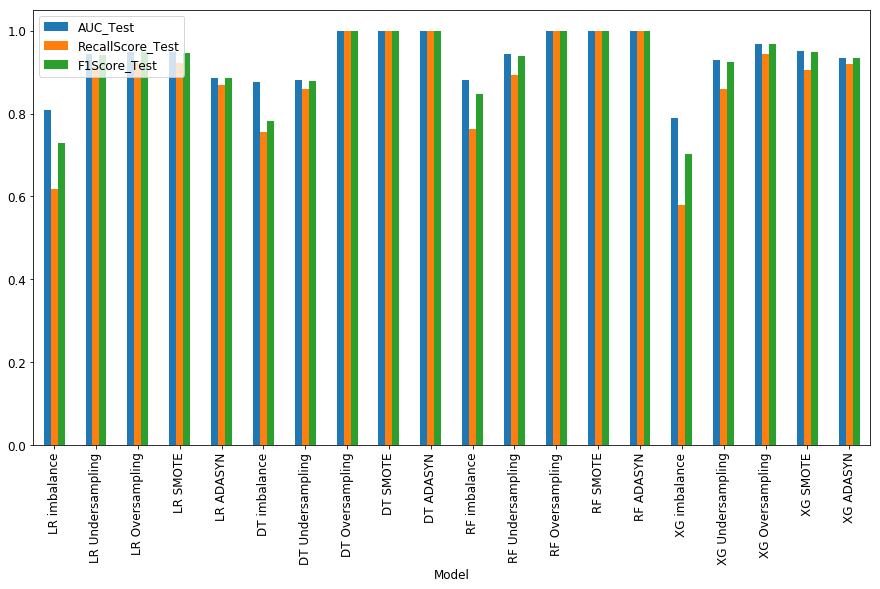

In [80]:
df = pd.DataFrame(performance_df,columns=['Model','AUC_Test','RecallScore_Test','F1Score_Test'])
df.plot(x ='Model', kind = 'bar', figsize=(15, 8))
plt.show()

### Hightlights

After training each of the models, these are the final results. All of the scores for Random Forest with Oversampling technique and the Random Forest with SMOTE technique models are very promising for our dataset! Each model has a high true positive rate and a low false-positive rate, which is exactly what we’re looking for.

In the ROC graph above, the AUC scores for Random Forest with Oversampling technique is pretty high, which is what we’d like to see. As we move further right along the curve, we both capture more True Positives but also incur more False Positives. This means we capture more fraudulent transactions, but also flag even more normal transactions as fraudulent.   
#### So Random Forest with Oversampling technique  is our final model, as this gives highest Recall score of 100% on both train and test datasets.